In [29]:
# ================================================================
# 1: Import Libraries
# ================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import cross_val_score, GridSearchCV
import warnings
warnings.filterwarnings('ignore')
import time

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('default')
sns.set_palette([ "#1f4e79" ])   # a strong, navy‑blue

print("📚 Libraries imported successfully!")

📚 Libraries imported successfully!


In [30]:
# ================================================================
# 2. LOAD SAVED DATA
# ================================================================
print("📂 Loading saved training and test data...")
print("=" * 50)

try:
    # Load features
    X_train_rf = pd.read_csv('../Data/output/X_train_encoded.csv')
    X_test_rf = pd.read_csv('../Data/output/X_test_encoded.csv')
    
    # Load labels
    y_train_rf = pd.read_csv('../Data/output/y_train.csv').squeeze()  # squeeze() converts DataFrame to Series
    y_test_rf = pd.read_csv('../Data/output/y_test.csv').squeeze()
    
    print("✅ Data loaded successfully!")
    print(f"   Training features: {X_train_rf.shape}")
    print(f"   Test features: {X_test_rf.shape}")
    print(f"   Training labels: {y_train_rf.shape}")
    print(f"   Test labels: {y_test_rf.shape}")
    
except FileNotFoundError as e:
    print(f"❌ Error: Could not find data files. {e}")
    print("Make sure you've run the encoding notebook first!")
except Exception as e:
    print(f"❌ Error loading data: {e}")

📂 Loading saved training and test data...
✅ Data loaded successfully!
   Training features: (22180, 20)
   Test features: (5545, 20)
   Training labels: (22180,)
   Test labels: (5545,)


In [31]:
# ================================================================
# 3. ANALYZE CLASS DISTRIBUTION (DETERMINES BEST SCORING METRIC)
# ================================================================

print("📊 ANALYZING CLASS DISTRIBUTION")
print("=" * 50)

# Check target variable distribution using your training data
class_counts = pd.Series(y_train_rf).value_counts().sort_index()
class_percentages = pd.Series(y_train_rf).value_counts(normalize=True).sort_index() * 100

print("Class distribution in training data:")
for class_label, count in class_counts.items():
    percentage = class_percentages[class_label]
    print(f"  Class {class_label}: {count:,} samples ({percentage:.1f}%)")

# Calculate imbalance ratio
max_class_count = class_counts.max()
min_class_count = class_counts.min()
imbalance_ratio = max_class_count / min_class_count

print(f"\n📈 Imbalance Analysis:")
print(f"  Largest class: {max_class_count:,} samples")
print(f"  Smallest class: {min_class_count:,} samples")
print(f"  Imbalance ratio: {imbalance_ratio:.2f}:1")

# Determine best scoring metric
if imbalance_ratio > 2.0:
    print("⚠️  Dataset appears imbalanced - F1-weighted recommended")
    recommended_scoring = 'f1_weighted'
    scoring_explanation = "F1-weighted handles class imbalance better than accuracy"
else:
    print("✅ Dataset appears balanced - accuracy is acceptable")
    recommended_scoring = 'accuracy'
    scoring_explanation = "Accuracy is reliable for balanced datasets"

print(f"🎯 Recommended scoring: {recommended_scoring}")
print(f"💡 Why: {scoring_explanation}")

📊 ANALYZING CLASS DISTRIBUTION
Class distribution in training data:
  Class 0: 4,237 samples (19.1%)
  Class 1: 5,634 samples (25.4%)
  Class 2: 12,309 samples (55.5%)

📈 Imbalance Analysis:
  Largest class: 12,309 samples
  Smallest class: 4,237 samples
  Imbalance ratio: 2.91:1
⚠️  Dataset appears imbalanced - F1-weighted recommended
🎯 Recommended scoring: f1_weighted
💡 Why: F1-weighted handles class imbalance better than accuracy


In [32]:
# ================================================================
# 4. DEFINE PARAMETER GRIDS (CHOOSE YOUR SPEED VS THOROUGHNESS)
# ================================================================

print(f"\n🔧 PARAMETER GRID OPTIONS")
print("=" * 50)

# Option 1: FAST Grid (20-30 minutes)
fast_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None]
}

# Option 2: COMPREHENSIVE Grid (1-2 hours)
comprehensive_param_grid = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2', 0.3, 0.5],
    'class_weight': ['balanced', None],
    'bootstrap': [True, False]
}

# Option 3: SMART Grid (30-60 minutes) - RECOMMENDED
smart_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'max_features': ['sqrt', 'log2', 0.3],
    'class_weight': ['balanced', None]
}

# Choose which grid to use (CHANGE THIS IF YOU WANT DIFFERENT SPEED)
#chosen_param_grid = smart_param_grid  # RECOMMENDED
#grid_name = "SMART"
chosen_param_grid = comprehensive_param_grid  # RECOMMENDED
grid_name = "COMPREHENSIVE"

# Calculate combinations
total_combinations = np.prod([len(v) for v in chosen_param_grid.values()])
print(f"🎯 Using {grid_name} parameter grid")
print(f"📊 Total combinations to test: {total_combinations}")

if grid_name == "FAST":
    print("⏱️  Estimated time: 20-30 minutes")
elif grid_name == "SMART":
    print("⏱️  Estimated time: 30-60 minutes")
else:
    print("⏱️  Estimated time: 1-2 hours")


🔧 PARAMETER GRID OPTIONS
🎯 Using COMPREHENSIVE parameter grid
📊 Total combinations to test: 5120
⏱️  Estimated time: 1-2 hours


In [33]:
# ================================================================
# 5. SETUP MULTI-SCORING GRIDSEARCHCV
# ================================================================

print(f"\n🎯 GRIDSEARCHCV CONFIGURATION")
print("=" * 50)

# Define multiple scoring metrics
scoring_metrics = {
    'accuracy': 'accuracy',
    'f1_weighted': 'f1_weighted',
    'f1_macro': 'f1_macro',
    'precision_weighted': 'precision_weighted',
    'recall_weighted': 'recall_weighted'
}

cv_folds = 5
print(f"🎯 Primary scoring metric: {recommended_scoring}")
print(f"📊 Additional metrics tracked: {list(scoring_metrics.keys())}")
print(f"🔄 Cross-validation folds: {cv_folds}")
print(f"💻 Parallel processing: Enabled (n_jobs=-1)")

# Configure GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid=chosen_param_grid,
    scoring=scoring_metrics,
    refit=recommended_scoring,  # Refit using the best metric for your data
    cv=cv_folds,               # n-fold CV for reasonable speed
    n_jobs=-1,                 # Use all CPU cores
    verbose=2,                 # Show detailed progress
    return_train_score=True    # Track overfitting
)


🎯 GRIDSEARCHCV CONFIGURATION
🎯 Primary scoring metric: f1_weighted
📊 Additional metrics tracked: ['accuracy', 'f1_weighted', 'f1_macro', 'precision_weighted', 'recall_weighted']
🔄 Cross-validation folds: 5
💻 Parallel processing: Enabled (n_jobs=-1)


In [34]:
# ================================================================
# 6. RUN GRIDSEARCHCV
# ================================================================

print(f"\n🚀 STARTING GRIDSEARCHCV...")
print("=" * 50)
print("📝 This will show detailed progress. Please wait...")

start_time = time.time()

# Fit GridSearchCV using your training data
grid_search.fit(X_train_rf, y_train_rf)

total_time = time.time() - start_time
print(f"\n✅ GridSearchCV COMPLETED!")
print(f"⏱️  Total runtime: {total_time:.1f} seconds ({total_time/60:.1f} minutes)")


🚀 STARTING GRIDSEARCHCV...
📝 This will show detailed progress. Please wait...
Fitting 5 folds for each of 5120 candidates, totalling 25600 fits

✅ GridSearchCV COMPLETED!
⏱️  Total runtime: 7046.0 seconds (117.4 minutes)


In [35]:
# ================================================================
# 7. EXTRACT AND DISPLAY RESULTS
# ================================================================

print(f"\n🏆 GRIDSEARCHCV RESULTS")
print("=" * 60)

# Display best parameters
print(f"🎯 BEST PARAMETERS (optimized for {recommended_scoring}):")
for param, value in grid_search.best_params_.items():
    print(f"   {param:20s}: {value}")

# Display best cross-validation scores for all metrics
print(f"\n📊 BEST CROSS-VALIDATION SCORES:")
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

for metric_name, metric_key in scoring_metrics.items():
    score_key = f'mean_test_{metric_name}'
    std_key = f'std_test_{metric_name}'
    
    if score_key in cv_results:
        mean_score = cv_results[score_key][best_index]
        std_score = cv_results[std_key][best_index]
        print(f"   {metric_name:20s}: {mean_score:.4f} ± {std_score:.4f}")


🏆 GRIDSEARCHCV RESULTS
🎯 BEST PARAMETERS (optimized for f1_weighted):
   bootstrap           : True
   class_weight        : balanced
   max_depth           : 10
   max_features        : sqrt
   min_samples_leaf    : 10
   min_samples_split   : 2
   n_estimators        : 200

📊 BEST CROSS-VALIDATION SCORES:
   accuracy            : 0.5637 ± 0.0045
   f1_weighted         : 0.5603 ± 0.0052
   f1_macro            : 0.4728 ± 0.0066
   precision_weighted  : 0.5581 ± 0.0061
   recall_weighted     : 0.5637 ± 0.0045


In [36]:
# ================================================================
# 8. EVALUATE BEST MODEL ON TEST SET
# ================================================================

print(f"\n🔮 FINAL MODEL EVALUATION ON TEST SET")
print("=" * 60)

# Get the best model (already trained)
best_rf_model = grid_search.best_estimator_

# Make predictions on your test set
print("📊 Making predictions on test set...")
y_pred_test = best_rf_model.predict(X_test_rf)

# Calculate test set metrics
test_accuracy = accuracy_score(y_test_rf, y_pred_test)
test_f1_weighted = f1_score(y_test_rf, y_pred_test, average='weighted')
test_f1_macro = f1_score(y_test_rf, y_pred_test, average='macro')

print(f"\n📈 TEST SET PERFORMANCE:")
print(f"   Accuracy:     {test_accuracy:.4f}")
print(f"   F1-Weighted:  {test_f1_weighted:.4f}")
print(f"   F1-Macro:     {test_f1_macro:.4f}")


🔮 FINAL MODEL EVALUATION ON TEST SET
📊 Making predictions on test set...

📈 TEST SET PERFORMANCE:
   Accuracy:     0.5625
   F1-Weighted:  0.5587
   F1-Macro:     0.4728


In [37]:
# ================================================================
# 9. DETAILED CLASSIFICATION REPORT
# ================================================================

print(f"\n📋 DETAILED CLASSIFICATION REPORT:")
print("=" * 60)
print(classification_report(y_test_rf, y_pred_test))


📋 DETAILED CLASSIFICATION REPORT:
              precision    recall  f1-score   support

           0       0.31      0.35      0.33      1059
           1       0.40      0.33      0.36      1410
           2       0.71      0.74      0.73      3076

    accuracy                           0.56      5545
   macro avg       0.48      0.47      0.47      5545
weighted avg       0.56      0.56      0.56      5545




📊 CREATING CONFUSION MATRIX...

📋 CONFUSION MATRIX (Plain Text):
Predicted    0    1     2
Actual                   
0          368  299   392
1          419  465   526
2          401  389  2286


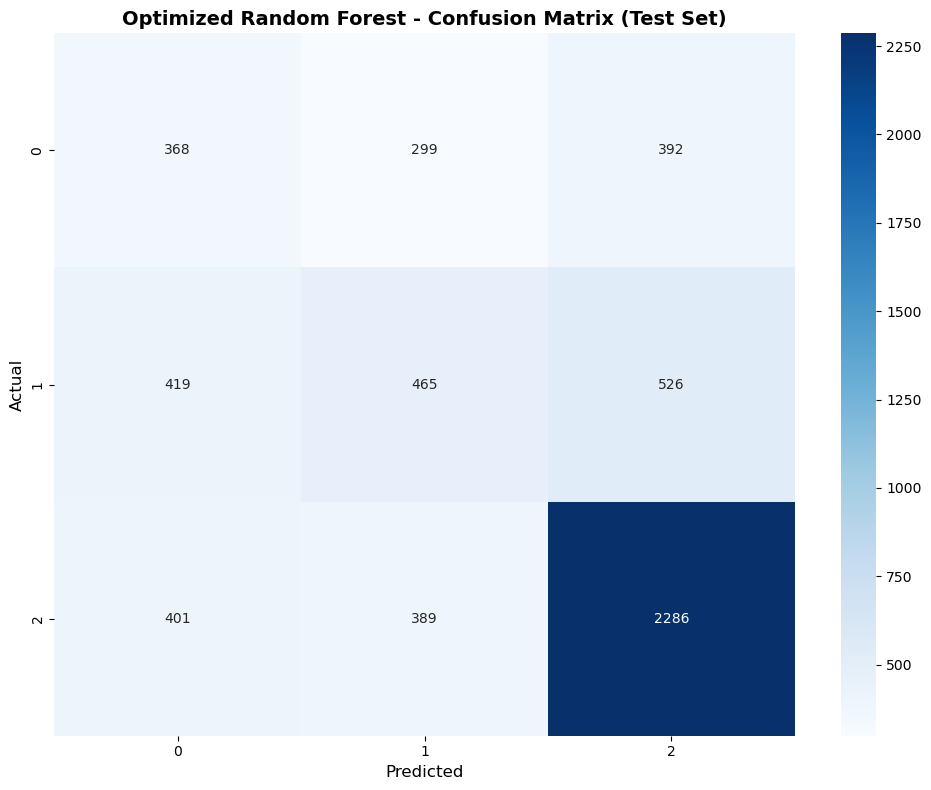

In [38]:
# ================================================================
# 10. CONFUSION MATRIX VISUALIZATION
# ================================================================

print(f"\n📊 CREATING CONFUSION MATRIX...")

# Calculate confusion matrix
cm = confusion_matrix(y_test_rf, y_pred_test)

# Get unique class labels
class_labels = sorted(np.unique(y_train_rf))

# Create plain-text confusion matrix table
print(f"\n📋 CONFUSION MATRIX (Plain Text):")
print("=" * 50)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.index.name = 'Actual'
cm_df.columns.name = 'Predicted'
print(cm_df)
print("=" * 50)

# Create confusion matrix plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Optimized Random Forest - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.tight_layout()
plt.show()

In [39]:
# ================================================================
# 11. TOP PARAMETER COMBINATIONS ANALYSIS
# ================================================================

print(f"\n🔍 TOP 5 PARAMETER COMBINATIONS")
print("=" * 60)

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(grid_search.cv_results_)
primary_score_col = f'mean_test_{recommended_scoring}'

# Get top 5 combinations
top_5_results = results_df.nlargest(5, primary_score_col)

print(f"🏆 Top 5 combinations (ranked by {recommended_scoring}):")
print("-" * 80)

for i, (idx, row) in enumerate(top_5_results.iterrows(), 1):
    score = row[primary_score_col]
    std_score = row[f'std_test_{recommended_scoring}']
    params = row['params']
    
    print(f"{i}. Score: {score:.4f} ± {std_score:.4f}")
    print(f"   Parameters: {params}")
    print()


🔍 TOP 5 PARAMETER COMBINATIONS
🏆 Top 5 combinations (ranked by f1_weighted):
--------------------------------------------------------------------------------
1. Score: 0.5603 ± 0.0052
   Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 200}

2. Score: 0.5603 ± 0.0052
   Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 5, 'n_estimators': 200}

3. Score: 0.5603 ± 0.0052
   Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 10, 'n_estimators': 200}

4. Score: 0.5603 ± 0.0052
   Parameters: {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 15, 'n_estimators': 200}

5. Score: 0.5603 ± 0.0052
   Parameters


🔍 FEATURE IMPORTANCE ANALYSIS
📊 TOP 10 MOST IMPORTANT FEATURES:
--------------------------------------------------
 1. excellent_Score          : 0.2557
 2. student_engagementt      : 0.2509
 3. active_in_VLE            : 0.1421
 4. imd_band_ord             : 0.1090
 5. highest_education_ord    : 0.0826
 6. disability_binary        : 0.0263
 7. age_band_ord             : 0.0238
 8. region_Wales             : 0.0121
 9. courses_per_term         : 0.0114
10. region_Scotland          : 0.0102


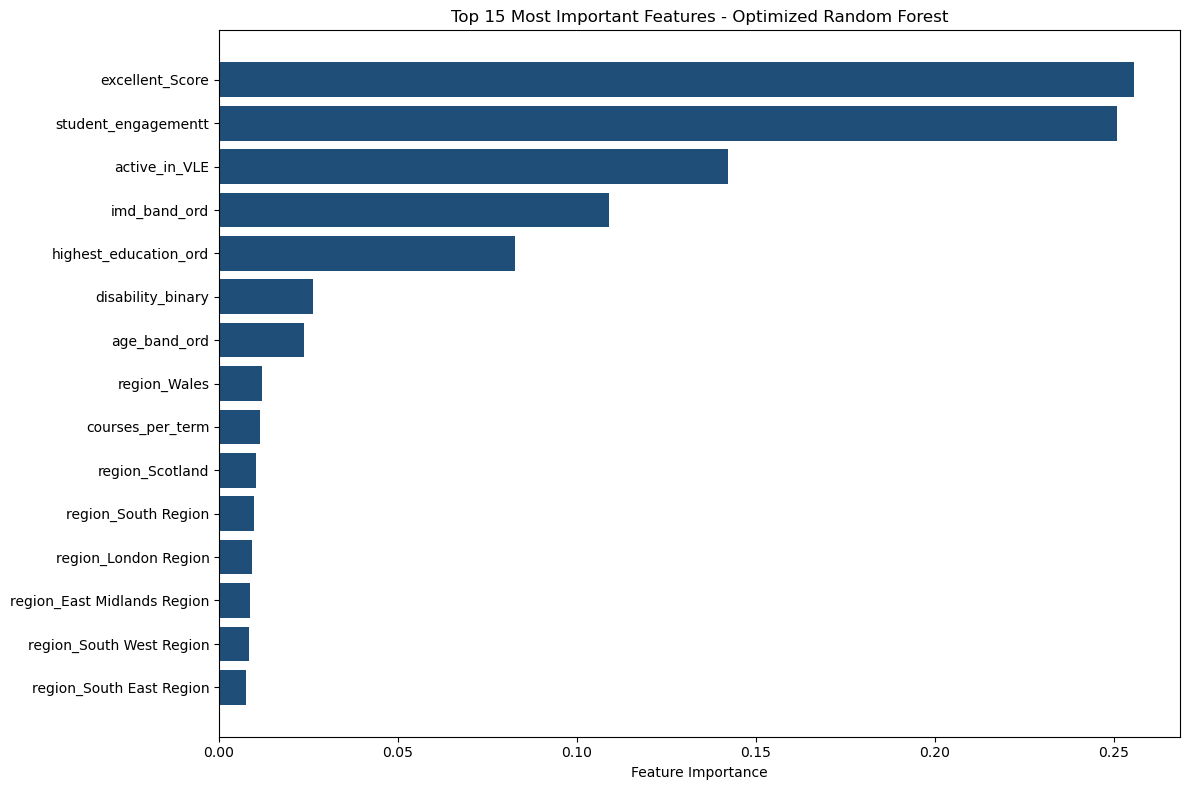

In [40]:
# ================================================================
# 10. FEATURE IMPORTANCE ANALYSIS
# ================================================================

print(f"\n🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature importance from best model
feature_importance = best_rf_model.feature_importances_

# Assuming your features are the columns of X_train_rf
# If X_train_rf is a DataFrame, get column names; if array, create generic names
try:
    if hasattr(X_train_rf, 'columns'):
        feature_names = X_train_rf.columns.tolist()
    else:
        feature_names = [f'feature_{i}' for i in range(X_train_rf.shape[1])]
except:
    feature_names = [f'feature_{i}' for i in range(len(feature_importance))]

# Create feature importance DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(f"📊 TOP 10 MOST IMPORTANT FEATURES:")
print("-" * 50)
for i, (_, row) in enumerate(importance_df.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']:25s}: {row['importance']:.4f}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features = importance_df.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 15 Most Important Features - Optimized Random Forest')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [41]:
# ================================================================
# 13. FINAL OPTIMIZED MODEL CODE
# ================================================================

print(f"\n💾 OPTIMIZED MODEL FOR PRODUCTION")
print("=" * 60)

print("✅ Your optimized Random Forest model:")
print()
print("# Copy-paste this code to create your optimized model")
print("optimized_rf = RandomForestClassifier(")
for param, value in grid_search.best_params_.items():
    if isinstance(value, str):
        print(f"    {param}='{value}',")
    else:
        print(f"    {param}={value},")
print("    random_state=42,")
print("    n_jobs=-1")
print(")")
print()
print("# Train and use the model")
print("optimized_rf.fit(X_train_rf, y_train_rf)")
print("y_pred = optimized_rf.predict(X_test_rf)")


💾 OPTIMIZED MODEL FOR PRODUCTION
✅ Your optimized Random Forest model:

# Copy-paste this code to create your optimized model
optimized_rf = RandomForestClassifier(
    bootstrap=True,
    class_weight='balanced',
    max_depth=10,
    max_features='sqrt',
    min_samples_leaf=10,
    min_samples_split=2,
    n_estimators=200,
    random_state=42,
    n_jobs=-1
)

# Train and use the model
optimized_rf.fit(X_train_rf, y_train_rf)
y_pred = optimized_rf.predict(X_test_rf)


In [42]:
# ================================================================
# 14. PERFORMANCE COMPARISON
# ================================================================

print(f"\n📈 PERFORMANCE SUMMARY")
print("=" * 60)

print(f"🎯 Optimization Results:")
print(f"   Best CV {recommended_scoring}: {grid_search.best_score_:.4f}")
print(f"   Test set accuracy:           {test_accuracy:.4f}")
print(f"   Test set F1-weighted:        {test_f1_weighted:.4f}")
print(f"   Test set F1-macro:           {test_f1_macro:.4f}")

print(f"\n⚙️  Best Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"   {param}: {value}")

print(f"\n⏱️  Optimization Details:")
print(f"   Total combinations tested: {total_combinations}")
print(f"   Cross-validation folds: 3")
print(f"   Runtime: {total_time/60:.1f} minutes")
print(f"   Primary scoring metric: {recommended_scoring}")

print(f"\n🎉 OPTIMIZATION COMPLETE!")
print("Your Random Forest model is now optimized and ready to use!")


📈 PERFORMANCE SUMMARY
🎯 Optimization Results:
   Best CV f1_weighted: 0.5603
   Test set accuracy:           0.5625
   Test set F1-weighted:        0.5587
   Test set F1-macro:           0.4728

⚙️  Best Hyperparameters:
   bootstrap: True
   class_weight: balanced
   max_depth: 10
   max_features: sqrt
   min_samples_leaf: 10
   min_samples_split: 2
   n_estimators: 200

⏱️  Optimization Details:
   Total combinations tested: 5120
   Cross-validation folds: 3
   Runtime: 117.4 minutes
   Primary scoring metric: f1_weighted

🎉 OPTIMIZATION COMPLETE!
Your Random Forest model is now optimized and ready to use!


In [43]:
# ================================================================
# 15. CREATE DIRECTORIES AND SAVE MODEL RESULTS
# ================================================================

import os
import joblib
import json
from datetime import datetime

print(f"\n💾 SAVING MODEL RESULTS")
print("=" * 60)

# Create directory structure
base_dir = "../Data"  # Go up one level from Notebooks to reach Data
model_metrics_dir = os.path.join(base_dir, "model_metrics")
models_dir = os.path.join(model_metrics_dir, "models")
metrics_dir = os.path.join(model_metrics_dir, "metrics")
reports_dir = os.path.join(model_metrics_dir, "reports")

# Create directories if they don't exist
os.makedirs(models_dir, exist_ok=True)
os.makedirs(metrics_dir, exist_ok=True) 
os.makedirs(reports_dir, exist_ok=True)

print(f"✅ Created directory structure:")
print(f"   📁 {model_metrics_dir}")
print(f"   📁 {models_dir}")
print(f"   📁 {metrics_dir}")
print(f"   📁 {reports_dir}")


💾 SAVING MODEL RESULTS
✅ Created directory structure:
   📁 ../Data\model_metrics
   📁 ../Data\model_metrics\models
   📁 ../Data\model_metrics\metrics
   📁 ../Data\model_metrics\reports


In [44]:
# ================================================================
# 16. SAVE THE TRAINED MODEL
# ================================================================

print(f"\n🤖 SAVING TRAINED MODEL")
print("=" * 60)

# Create timestamp for unique filenames
#timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
#model_name = f"random_forest_optimized_{timestamp}"
model_name = "random_forest_optimized"

# Save the trained model
model_path = os.path.join(models_dir, f"{model_name}.pkl")
joblib.dump(best_rf_model, model_path)

print(f"✅ Model saved to: {model_path}")
print(f"📏 Model file size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")


🤖 SAVING TRAINED MODEL
✅ Model saved to: ../Data\model_metrics\models\random_forest_optimized.pkl
📏 Model file size: 5.94 MB


In [ ]:
# ================================================================
# 17. SAVE MODEL METRICS AND PERFORMANCE DATA (FIXED)
# ================================================================

print(f"\n📊 SAVING PERFORMANCE METRICS")
print("=" * 60)

# Helper function to convert numpy types to Python native types
def convert_numpy_types(obj):
    """Convert numpy types to Python native types for JSON serialization"""
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, dict):
        return {key: convert_numpy_types(value) for key, value in obj.items()}
    elif isinstance(obj, list):
        return [convert_numpy_types(item) for item in obj]
    else:
        return obj

# Prepare comprehensive metrics dictionary
model_metrics = {
    "model_info": {
        "model_name": "Random Forest Classifier",
        #"timestamp": timestamp,
        "optimization_method": "GridSearchCV",
        "primary_scoring_metric": recommended_scoring,
        "total_runtime_minutes": round(total_time/60, 2)
    },
    "dataset_info": {
        "training_samples": int(X_train_rf.shape[0]),
        "test_samples": int(X_test_rf.shape[0]),
        "n_features": int(X_train_rf.shape[1]),
        "n_classes": int(len(np.unique(y_train_rf))),
        "class_distribution": {str(k): int(v) for k, v in class_counts.items()}
    },
    "hyperparameters": {
        "best_params": convert_numpy_types(grid_search.best_params_),
        "total_combinations_tested": int(total_combinations),
        "cv_folds": cv_folds
    },
    "cross_validation_results": {
        "best_cv_score": float(grid_search.best_score_),
        "cv_scores_by_metric": {}
    },
    "test_set_performance": {
        "accuracy": float(test_accuracy),
        "f1_weighted": float(test_f1_weighted),
        "f1_macro": float(test_f1_macro)
    },
    "feature_importance": {
        "top_10_features": [
            {
                "feature": str(row['feature']),
                "importance": float(row['importance'])
            }
            for _, row in importance_df.head(10).iterrows()
        ]
    }
}

# Add detailed CV results for all metrics
cv_results = grid_search.cv_results_
best_index = grid_search.best_index_

for metric_name in scoring_metrics.keys():
    score_key = f'mean_test_{metric_name}'
    std_key = f'std_test_{metric_name}'
    
    if score_key in cv_results:
        model_metrics["cross_validation_results"]["cv_scores_by_metric"][metric_name] = {
            "mean": float(cv_results[score_key][best_index]),
            "std": float(cv_results[std_key][best_index])
        }

# Convert the entire dictionary to ensure all numpy types are handled
model_metrics = convert_numpy_types(model_metrics)

# Save metrics as JSON
metrics_path = os.path.join(metrics_dir, f"{model_name}_metrics.json")
with open(metrics_path, 'w') as f:
    json.dump(model_metrics, f, indent=2)

print(f"✅ Metrics saved to: {metrics_path}")


📊 SAVING PERFORMANCE METRICS
✅ Metrics saved to: ../Data\model_metrics\metrics\random_forest_optimized_metrics.json


In [46]:
# ================================================================
# 18. SAVE DETAILED CLASSIFICATION REPORT
# ================================================================

print(f"\n📋 SAVING CLASSIFICATION REPORT")
print("=" * 60)

# Generate detailed classification report
from sklearn.metrics import classification_report

# Get classification report as dictionary
class_report_dict = classification_report(y_test_rf, y_pred_test, output_dict=True)

# Save classification report
report_path = os.path.join(reports_dir, f"{model_name}_classification_report.json")
with open(report_path, 'w') as f:
    json.dump(class_report_dict, f, indent=2)

print(f"✅ Classification report saved to: {report_path}")

# Also save as text format for easy reading
report_text_path = os.path.join(reports_dir, f"{model_name}_classification_report.txt")
with open(report_text_path, 'w') as f:
    f.write("RANDOM FOREST CLASSIFICATION REPORT\n")
    f.write("=" * 50 + "\n\n")
    f.write(f"Model: {model_name}\n")
    #f.write(f"Timestamp: {timestamp}\n")
    f.write(f"Primary Metric: {recommended_scoring}\n\n")
    f.write("DETAILED CLASSIFICATION REPORT:\n")
    f.write("-" * 30 + "\n")
    f.write(classification_report(y_test_rf, y_pred_test))

print(f"✅ Text report saved to: {report_text_path}")


📋 SAVING CLASSIFICATION REPORT
✅ Classification report saved to: ../Data\model_metrics\reports\random_forest_optimized_classification_report.json
✅ Text report saved to: ../Data\model_metrics\reports\random_forest_optimized_classification_report.txt


In [47]:
# ================================================================
# 19. SAVE CONFUSION MATRIX DATA
# ================================================================

print(f"\n🔢 SAVING CONFUSION MATRIX")
print("=" * 60)

# Save confusion matrix data
confusion_matrix_data = {
    "confusion_matrix": cm.tolist(),
    "class_labels": sorted(np.unique(y_train_rf).tolist()),
    "model_name": model_name,
    #"timestamp": timestamp
}

cm_path = os.path.join(metrics_dir, f"{model_name}_confusion_matrix.json")
with open(cm_path, 'w') as f:
    json.dump(confusion_matrix_data, f, indent=2)

print(f"✅ Confusion matrix saved to: {cm_path}")

# Save confusion matrix to text file
cm_txt_path = os.path.join(metrics_dir, f"{model_name}_confusion_matrix.txt")
with open(cm_txt_path, 'w') as f:
    f.write(f"Confusion Matrix for {model_name}\n")
    f.write("=" * 50 + "\n\n")
    
    # Write class labels header
    class_labels = sorted(np.unique(y_train_rf).tolist())
    f.write("Class Labels: " + ", ".join(map(str, class_labels)) + "\n\n")
    
    # Write confusion matrix in a readable format
    f.write("Confusion Matrix:\n")
    f.write("-" * 30 + "\n")
    
    # Header row with class labels
    f.write("Actual\\Predicted\t" + "\t".join(map(str, class_labels)) + "\n")
    
    # Matrix rows
    for i, row in enumerate(cm):
        f.write(f"{class_labels[i]}\t\t\t" + "\t".join(map(str, row)) + "\n")

print(f"✅ Confusion matrix also saved to: {cm_txt_path}")


🔢 SAVING CONFUSION MATRIX
✅ Confusion matrix saved to: ../Data\model_metrics\metrics\random_forest_optimized_confusion_matrix.json
✅ Confusion matrix also saved to: ../Data\model_metrics\metrics\random_forest_optimized_confusion_matrix.txt


In [48]:
# ================================================================
# 20. SAVE FEATURE IMPORTANCE DATA
# ================================================================

print(f"\n🎯 SAVING FEATURE IMPORTANCE")
print("=" * 60)

# Save feature importance as CSV for easy analysis
importance_path = os.path.join(metrics_dir, f"{model_name}_feature_importance.csv")
importance_df.to_csv(importance_path, index=False)

print(f"✅ Feature importance saved to: {importance_path}")

# Also save as JSON
importance_json_path = os.path.join(metrics_dir, f"{model_name}_feature_importance.json")
importance_json = {
    "model_name": model_name,
    #"timestamp": timestamp,
    "feature_importance": [
        {
            "rank": i + 1,
            "feature": row['feature'],
            "importance": float(row['importance'])
        }
        for i, (_, row) in enumerate(importance_df.iterrows())
    ]
}

with open(importance_json_path, 'w') as f:
    json.dump(importance_json, f, indent=2)

print(f"✅ Feature importance JSON saved to: {importance_json_path}")


🎯 SAVING FEATURE IMPORTANCE
✅ Feature importance saved to: ../Data\model_metrics\metrics\random_forest_optimized_feature_importance.csv
✅ Feature importance JSON saved to: ../Data\model_metrics\metrics\random_forest_optimized_feature_importance.json


In [49]:
# ================================================================
# 21. CREATE MODEL LOADING INSTRUCTIONS
# ================================================================

print(f"\n📖 SAVING MODEL USAGE INSTRUCTIONS")
print("=" * 60)

# Create instructions file
instructions = f"""
RANDOM FOREST MODEL USAGE INSTRUCTIONS
=====================================

Model Information:
- Model Name: {model_name}
- Model Type: Random Forest Classifier (Optimized)
- File Location: {model_path}

LOADING THE MODEL:
-----------------
```python
import joblib
import pandas as pd
import numpy as np

# Load the trained model
model = joblib.load('{model_path}')

# Make predictions on new data
# Ensure your new data has the same features as training data
predictions = model.predict(X_new)
prediction_probabilities = model.predict_proba(X_new)
```

BEST HYPERPARAMETERS:
-------------------
{json.dumps(grid_search.best_params_, indent=2)}

PERFORMANCE METRICS:
------------------
- Test Accuracy: {test_accuracy:.4f}
- Test F1-Weighted: {test_f1_weighted:.4f}
- Test F1-Macro: {test_f1_macro:.4f}
- Best CV Score ({recommended_scoring}): {grid_search.best_score_:.4f}

TOP 5 IMPORTANT FEATURES:
-----------------------
"""

for i, (_, row) in enumerate(importance_df.head(5).iterrows(), 1):
    instructions += f"{i}. {row['feature']}: {row['importance']:.4f}\n"

instructions += f"""

FILES SAVED:
-----------
- Model: {model_path}
- Metrics: {metrics_path}
- Classification Report: {report_path}
- Feature Importance: {importance_path}
- Usage Instructions: This file

NOTES:
-----
- This model was optimized using GridSearchCV
- Total combinations tested: {total_combinations}
- Cross-validation: 3-fold
- Optimization runtime: {total_time/60:.1f} minutes
- Primary scoring metric: {recommended_scoring}
"""

instructions_path = os.path.join(model_metrics_dir, f"{model_name}_USAGE_INSTRUCTIONS.txt")
with open(instructions_path, 'w') as f:
    f.write(instructions)

print(f"✅ Usage instructions saved to: {instructions_path}")


📖 SAVING MODEL USAGE INSTRUCTIONS
✅ Usage instructions saved to: ../Data\model_metrics\random_forest_optimized_USAGE_INSTRUCTIONS.txt


In [50]:
# ================================================================
# 22. SUMMARY OF SAVED FILES
# ================================================================

print(f"\n📁 COMPLETE SAVE SUMMARY")
print("=" * 60)

saved_files = [
    ("Trained Model", model_path),
    ("Metrics (JSON)", metrics_path),
    ("Classification Report (JSON)", report_path),
    ("Classification Report (Text)", report_text_path),
    ("Confusion Matrix", cm_path),
    ("Feature Importance (CSV)", importance_path),
    ("Feature Importance (JSON)", importance_json_path),
    ("Usage Instructions", instructions_path)
]

print("✅ All files successfully saved:")
for file_type, file_path in saved_files:
    file_size = os.path.getsize(file_path)
    if file_size > 1024*1024:
        size_str = f"{file_size/(1024*1024):.2f} MB"
    elif file_size > 1024:
        size_str = f"{file_size/1024:.2f} KB"
    else:
        size_str = f"{file_size} bytes"
    
    print(f"   📄 {file_type:25s}: {os.path.basename(file_path):40s} ({size_str})")

print(f"\n🎉 MODEL EXPORT COMPLETE!")
print(f"📂 All files are stored in: {model_metrics_dir}")
print(f"🔄 Model ID: {model_name}")

# Return model identifier for future reference
model_identifier = {
    "model_id": model_name,
    #"timestamp": timestamp,
    "model_path": model_path,
    "metrics_path": metrics_path
}

print(f"\n💡 To load this model later:")
print(f"   model = joblib.load('{model_path}')")


📁 COMPLETE SAVE SUMMARY
✅ All files successfully saved:
   📄 Trained Model            : random_forest_optimized.pkl              (5.94 MB)
   📄 Metrics (JSON)           : random_forest_optimized_metrics.json     (2.57 KB)
   📄 Classification Report (JSON): random_forest_optimized_classification_report.json (807 bytes)
   📄 Classification Report (Text): random_forest_optimized_classification_report.txt (608 bytes)
   📄 Confusion Matrix         : random_forest_optimized_confusion_matrix.json (278 bytes)
   📄 Feature Importance (CSV) : random_forest_optimized_feature_importance.csv (845 bytes)
   📄 Feature Importance (JSON): random_forest_optimized_feature_importance.json (2.34 KB)
   📄 Usage Instructions       : random_forest_optimized_USAGE_INSTRUCTIONS.txt (1.85 KB)

🎉 MODEL EXPORT COMPLETE!
📂 All files are stored in: ../Data\model_metrics
🔄 Model ID: random_forest_optimized

💡 To load this model later:
   model = joblib.load('../Data\model_metrics\models\random_forest_optimized.pkl')